In [355]:
import numpy as np
import random
import pickle
import chess
import sqlite3

In [529]:
class network:
    def __init__(self):
        self.layers = []
    
    def output(self, x):
        result = x
        
        # Compute values at each layer
        for layer in self.layers[:-1]:
            result = relu(np.dot(result, layer))
        
        # Apply softmax to final layer
        result = np.dot(result, self.layers[-1])
        #result = result / np.linalg.norm(result)
        result = result - np.max(result)
        result = np.exp(result) / np.sum(np.exp(result))
        
        return result

In [499]:
def fen_to_input(fen):
    piece_translator = {'P' : [ 1, 0, 0, 0, 0, 0],
                        'R' : [ 0, 1, 0, 0, 0, 0],
                        'N' : [ 0, 0, 1, 0, 0, 0],
                        'B' : [ 0, 0, 0, 1, 0, 0],
                        'Q' : [ 0, 0, 0, 0, 1, 0],
                        'K' : [ 0, 0, 0, 0, 0, 1],
                        'p' : [-1, 0, 0, 0, 0, 0],
                        'r' : [ 0,-1, 0, 0, 0, 0],
                        'n' : [ 0, 0,-1, 0, 0, 0],
                        'b' : [ 0, 0, 0,-1, 0, 0],
                        'q' : [ 0, 0, 0, 0,-1, 0],
                        'k' : [ 0, 0, 0, 0, 0,-1],
                        ' ' : [ 0, 0, 0, 0, 0, 0]}

    result = np.zeros((390,), dtype=np.int8)
    
    board, to_move, castling_rights, en_passant, halfmove, fullmove = fen.split(' ')
    
    ##
    board = board.replace('/', '')
    
    for i in range(1, 9):
        board = board.replace(str(i), ' ' * i)
        
    for i in range(len(board)):
        result[i:i+6] = piece_translator[board[i]]
    
    if to_move == 'w':
        result[384] = 1
    elif to_move == 'b':
        result[384] = -1
    
    if not en_passant == '-':
        row = 9 - int(en_passant[1])
        col = ord(en_passant[0]) - 96
        pos = row * col - 1

        result[385] = pos
        
    if 'K' in castling_rights:
        result[386] = 1

    if 'Q' in castling_rights:
        result[387] = 1

    if 'k' in castling_rights:
        result[388] = -1

    if 'q' in castling_rights:
        result[389] = -1
    
    

    return result

In [257]:
x = network()

x.layers.append( np.random.random((100, 100))-0.5)


for i in range(0, 10):
    m = x.layers[-1].shape[1]
    n = np.random.randint(10, 100)
    x.layers.append(np.random.random((m, n))-0.5)

x.layers.append( np.random.random((n, 2)) )

In [258]:
x.output(np.random.random((100,)))

array([ 0.49113603,  0.50886397])

In [474]:
def create_player_database(num_players):
    conn = sqlite3.connect('players.db')
    c = conn.cursor()
    c.execute('''DROP TABLE IF EXISTS players''')
    c.execute('''CREATE TABLE players (wins int, losses int, object blob)''')
    
    for i in range(num_players):
        # Create a new network
        x = network()
        
        # Add an input layer
        input_layer_size = np.random.randint(10, 100)
        x.layers.append( np.random.random((390, input_layer_size))-0.5)
        
        # Add 10 to 99 interior layers
        num_layers = np.random.randint(10, 100)
        for j in range(num_layers):
            m = x.layers[-1].shape[1]
            n = np.random.randint(10, 100)
            x.layers.append(np.random.random((m, n))-0.5)
        
        
        x.layers.append( np.random.random((n, 2)) - 0.5 )
        
        pdata = pickle.dumps(x, pickle.HIGHEST_PROTOCOL)
        
        c.execute("INSERT INTO players VALUES (0, 0, ?)", (sqlite3.Binary(pdata), ))
        
    conn.commit()
    conn.close()

def select_two_players():
    conn = sqlite3.connect('players.db')
    c = conn.cursor()
    c.execute('''SELECT * FROM players ORDER BY RANDOM() LIMIT 2;''')
    
    players = []
    for row in c:
        players.append( pickle.loads(row[2]) )
    
    return players[0], players[1]

In [534]:
def get_move(player, fen_string):
    playing_as = fen_string.split(' ')[1]
    if playing_as == 'w':
        score_index = 0
    else:
        score_index = 1
    
    board = chess.Board(fen_string)
    
    legal_moves = []
    for move in board.legal_moves:
        legal_moves.append(move)
    
    best_move = None
    max_score = 0
    
    for move in legal_moves:
        board.push(move)
        x = fen_to_input(board.fen())
        score = player.output(x)[score_index]
        board.pop()
        
        if score >= max_score:
            best_move = move
            max_score = score
        
    return best_move

1-0


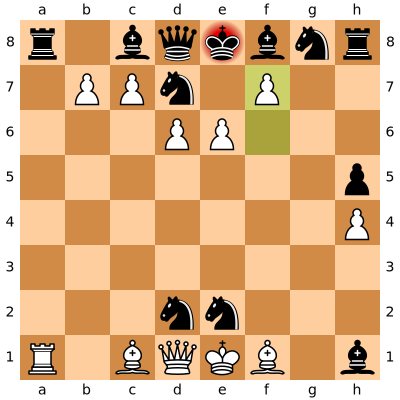

In [540]:
white_player, black_player = select_two_players()

board = chess.Board()

while not board.is_game_over():
    if board.turn:
        move = get_move(white_player, board.fen())
    else:
        move = get_move(black_player, board.fen())
        
    board.push(move)

print(board.result())
board